In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
np.seterr(over="raise")
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

zcross = lambda A: d3.MulCosine(d3.skew(A))
from mydedalustools import *

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


# Balanced height field and unstable eigenmodes in a 2-layer model

In [2]:
# Simulation units
meter = 1 / 6.4e6
hour = 1
second = hour / 3600
day = hour*24
taurad=1*day

# Parameters
Nphi = 128
Ntheta = 64
dealias = (3/2, 3/2)
R = 6.4e6 * meter
Omega = 2*np.pi/86400 / second
g = 10 * meter / second**2
deltarho_ov_rho1 = 0.1
gprime = g * deltarho_ov_rho1
#rho1_ov_rho2 = 1/(1+deltarho_ov_rho1)
H = 1e4 * meter
dtype = np.float64

Now let's build two bases for the sphere. First, one to just represent zonally constant fields, and second, one to represent full 2D fields on the sphere:

In [3]:
# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
full_basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=dealias, dtype=dtype)
zonal_basis = d3.SphereBasis(coords, (1, Ntheta), radius=R, dealias=dealias, dtype=dtype)

In [4]:
#%time sol_2l_HS_10day_ext  = open_h5('snapshots_2l_HeldSuarez_10days','s2')

## 1. Height field from imposed zonal jet (LBVP)

We start with prescribing a mid-latitude zonal jet, and solving a zonally-symmetric LBVP to find the height field that balances this jet profile.
This will be the background state of our eigenvalue problem.

First we build the background fields using the zonally symmetric basis:

In [15]:
u10 = dist.VectorField(coords, name='u10', bases=zonal_basis)
h10 = dist.Field(name='h10', bases=zonal_basis)
u20 = dist.VectorField(coords, name='u20', bases=zonal_basis)
h20 = dist.Field(name='h20', bases=zonal_basis)

Next let's setup the zonal jet (the details here are from the reference above):

In [16]:
# Setup zonal jet
phi, theta = dist.local_grids(zonal_basis)
lat = np.pi / 2 - theta + 0*phi
umax = 30 * meter / second
lat0 = np.pi/7
lat1 = np.pi / 2 - lat0
en = np.exp(-4 / (lat1 - lat0)**2)
#jet = (lat0 <= lat) * (lat <= lat1)
#u_jet = umax / en * np.exp(1 / (lat[jet] - lat0) / (lat[jet] - lat1))
#u10['g'][0][jet]  = u_jet
#u20['g'][0][jet]  = -u_jet
jet = (lat0 <= lat) * (lat <= lat1) 
jet2 =  (-lat0 >= lat) * (lat >= -lat1)
u_jet  = umax / en * np.exp(1 / (lat[jet] - lat0) / (lat[jet] - lat1))
u_jet2 = umax / en * np.exp(1 / (lat[jet2] + lat0) / (lat[jet2] + lat1))
u10['g'][0][jet]  = u_jet
u20['g'][0][jet]  = -u_jet
u10['g'][0][jet2]  = u_jet2
u20['g'][0][jet2]  = -u_jet2

We can now solve for the balancing height field (ignoring hyperdiffusivity).
This comes from taking the divergence of the momentum equation, and using a gauge freedom to fix the mean of $h$ to be 0:

In [17]:
# Find balanced height field
c1 = dist.Field(name='c1')
c2 = dist.Field(name='c2')
problem = d3.LBVP([h10,h20, c1,c2], namespace=locals())
problem.add_equation("g*lap(h10+h20) + c1 = - div(u10@grad(u10) + 2*Omega*zcross(u10))")
problem.add_equation("g*lap(h10+h20) + gprime*lap(h20) + c2 = - div(u20@grad(u20) + 2*Omega*zcross(u20))")
problem.add_equation("ave(h10) = H")
problem.add_equation("ave(h20) = H")
solver = problem.build_solver()
solver.solve()

2023-07-12 13:27:00,891 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+01/s


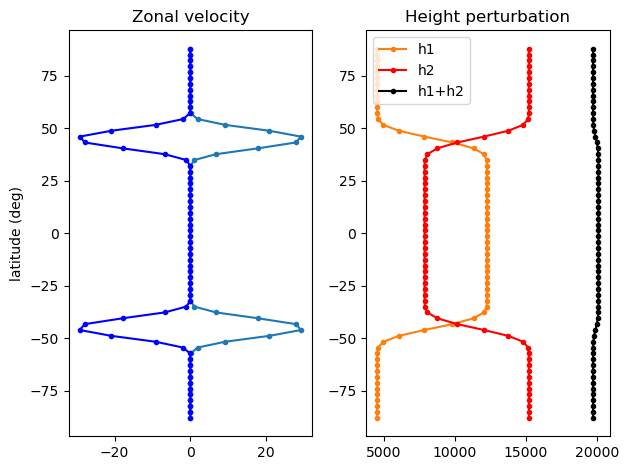

In [18]:
u10.change_scales(1)
h10.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)

fig, axs = plt.subplots(1,2)
axs[0].plot(u10['g'][0][0]/(meter/second), lat[0]*180/np.pi, '.-', color='C0')
axs[0].plot(u20['g'][0][0]/(meter/second), lat[0]*180/np.pi, '.-', color='b')
axs[0].set_title('Zonal velocity')
axs[0].set_ylabel('latitude (deg)')
axs[1].plot(h10['g'][0]/meter, lat[0]*180/np.pi, '.-', color='C1', label='h1')
axs[1].plot(h20['g'][0]/meter, lat[0]*180/np.pi, '.-', color='r', label='h2')
axs[1].plot((h10['g'][0]+h20['g'][0])/meter, lat[0]*180/np.pi, '.-', color='k', label='h1+h2')
axs[1].set_title('Height perturbation')
axs[1].legend()
plt.tight_layout()

## NLBVP

In [19]:
eps = 1.e-4
def step(A): 
    return 1./2. * (1. + np.tanh(A/eps))

In [20]:
Q = dist.Field(name='Q', bases=zonal_basis)
h20.change_scales(1)
Q['g'] = -(h20['g']-H)/taurad

# Find balanced height field
taurad=10*day
taudrag=100*day
nu = 1e5 * meter**2 / second / 32**2
problem_HS = d3.NLBVP([u10,u20], namespace=locals())
problem_HS.add_equation("nu*lap(lap(u10)) + 2*Omega*zcross(u10) + u10/taudrag = -g*grad(h10+h20) + (u20-u10)/h10*Q*step(Q)")
problem_HS.add_equation("nu*lap(lap(u20)) + 2*Omega*zcross(u20) + u20/taudrag = -g*grad(h10+h20) - gprime*grad(h20) - (u10-u20)/h20*Q*step(-Q)")


ncc_cutoff = 1e-4
tolerance = 1e-5
u10.change_scales(dealias)
h10.change_scales(dealias)
u20.change_scales(dealias)
h20.change_scales(dealias)
Q.change_scales(dealias)
solver_HS = problem_HS.build_solver(ncc_cutoff=ncc_cutoff),
pert_norm = np.inf

while pert_norm > tolerance:
    print(len(solver_HS))
    solver_HS[0].newton_iteration(damping=1)
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver_HS[0].perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')

1
2023-07-12 13:27:05,722 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s
2023-07-12 13:27:05,723 __main__ 0/1 INFO :: Perturbation norm: 5.769e-04
1
2023-07-12 13:27:06,475 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s
2023-07-12 13:27:06,476 __main__ 0/1 INFO :: Perturbation norm: 1.338e-07


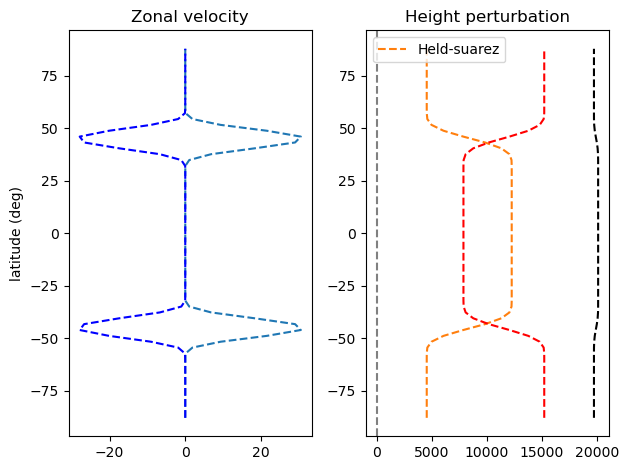

In [21]:
u10.change_scales(1)
h10.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)

fig, axs = plt.subplots(1,2)
axs[0].plot(u10['g'][0][0]/(meter/second), lat[0]*180/np.pi, '--', color='C0')
axs[0].plot(u20['g'][0][0]/(meter/second), lat[0]*180/np.pi, '--', color='b')
axs[0].set_title('Zonal velocity')
axs[0].set_ylabel('latitude (deg)')
axs[1].plot(h10['g'][0]/meter, lat[0]*180/np.pi, '--', color='C1', label='Held-suarez')
axs[1].plot(h20['g'][0]/meter, lat[0]*180/np.pi, '--', color='r')
axs[1].plot((h10['g'][0]+h20['g'][0])/meter, lat[0]*180/np.pi, '--', color='k')
axs[1].axvline(0.,color='gray',linestyle='--')
axs[1].set_title('Height perturbation')
axs[1].legend()
plt.tight_layout()

# TEST

In [44]:
# Parameters
Nphi = 128
Ntheta = 64
dealias = (3/2, 3/2)
dtype = np.float64

# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24

#########################################
#########################################
###############  SET    #################
snapshot_id = 'snapshots_2l_earthlike_10days_vmt'
axisymmetric = True
vmt=True
restart=False; restart_id='s1'
timestep = 200*second
stop_sim_time = 500*hour
#########################################
#########################################

# # Tidally-locked planet
# taurad = 0.1*day
# taudrag = 10 * day
# Omega = 3.2e-5 / second
# R = 8.2e7 * meter
# gprime = 10*meter/second**2
# deltarho_ov_rho1 = 0.1
# rho1_ov_rho2 = 1/(1+deltarho_ov_rho1)
# g = gprime/deltarho_ov_rho1
# H0 = 4e6 * meter**2/second**2 / gprime
# DeltaHeq = 0.5*H0


# Earth-like planet
taurad = 10*day
taudrag = 100 * day
Omega = 2*np.pi/86400 / second 
R = 6400e3 * meter
g = 10*meter/second**2
deltarho_ov_rho1 = 0.1
gprime = g * deltarho_ov_rho1

rho1_ov_rho2 = 1#/(1+deltarho_ov_rho1)
H0 = 1e4*meter
DeltaHeq = 1.4*H0

print("Deformation radius: %.1f km"%(np.sqrt(gprime*H0)/Omega/meter/1e3))


nu = 1e5 * meter**2 / second / 32**2 # hyperdiffusion constant

# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)#
full_basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=dealias, dtype=dtype)
zonal_basis = d3.SphereBasis(coords, (1, Ntheta), radius=R, dealias=dealias, dtype=dtype)

# Nonlinearity
eps = 1.e-4
def step(A): 
    return 1./2. * (1. + np.tanh(A/eps))
# cross product by zhat
zcross = lambda A: d3.MulCosine(d3.skew(A))

###############################
###### INITIALIZE FIELDS ######
###############################
u10 = dist.VectorField(coords, name='u10', bases=zonal_basis)
h10 = dist.Field(name='h10', bases=zonal_basis)
u20 = dist.VectorField(coords, name='u20', bases=zonal_basis)
h20 = dist.Field(name='h20', bases=zonal_basis)

# Setup zonal jet
phi, theta = dist.local_grids(zonal_basis)
lat = np.pi / 2 - theta + 0*phi
umax = 30 * meter / second
lat0 = np.pi/7
lat1 = np.pi / 2 - lat0
en = np.exp(-4 / (lat1 - lat0)**2)
jet = (lat0 <= lat) * (lat <= lat1) 
jet2 =  (-lat0 >= lat) * (lat >= -lat1)
u_jet  = umax / en * np.exp(1 / (lat[jet] - lat0) / (lat[jet] - lat1))
u_jet2 = umax / en * np.exp(1 / (lat[jet2] + lat0) / (lat[jet2] + lat1))
u10['g'][0][jet]  = u_jet
u20['g'][0][jet]  = -u_jet
u10['g'][0][jet2]  = u_jet2
u20['g'][0][jet2]  = -u_jet2


# Find balanced height field
c1 = dist.Field(name='c1')
c2 = dist.Field(name='c2')
problem = d3.LBVP([h10,h20, c1,c2], namespace=locals())
problem.add_equation("g*lap(h10+h20) + c1 = - div(u10@grad(u10) + 2*Omega*zcross(u10) + u10/taudrag)")
problem.add_equation("g*lap(h10+h20) + gprime*lap(h20) + c2 = - div(u20@grad(u20) + 2*Omega*zcross(u20)+ u20/taudrag)")
problem.add_equation("ave(h10) = 0")
problem.add_equation("ave(h20) = 0")
solver = problem.build_solver()
solver.solve()
    
u10.change_scales(1)
h10.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)

u1_init = dist.VectorField(coords, name='u1_init', bases=full_basis)
h1_init = dist.Field(name='h1_init', bases=full_basis)
u2_init = dist.VectorField(coords, name='u2_init', bases=full_basis)
h2_init = dist.Field(name='h2_init', bases=full_basis)
phi, theta = dist.local_grids(full_basis)
lat = np.pi/2-theta
lon = phi-np.pi

if axisymmetric:
    u1_init['g'] = u10['g']
    h1_init['g'] = h10['g']+H0
    u2_init['g'] = u20['g']
    h2_init['g'] = h20['g']+H0
if not axisymmetric:
    h1_init['g'] = 0.5*(h10['g']-(-0.001592359539824521))*np.cos(lon) + H0
    h2_init['g'] = 0.5*(h20['g']-0.001513985905602202)*np.cos(lon) + H0
    u1_init = d3.skew(g*d3.grad(h1_init+h2_init)).evaluate()
    u1_init.change_scales(1)
    u1_init['g']/=(2*Omega*np.sin(lat))
    u2_init = d3.skew(g*d3.grad(h1_init+h2_init)+gprime*d3.grad(h2_init)).evaluate()
    u2_init.change_scales(1)
    u2_init['g']/=(2*Omega*np.sin(lat))
if vmt:
    h10['g'] = h10['g']+H0
    h20['g'] = h20['g']+H0
    Q = dist.Field(name='Q', bases=zonal_basis)
    h20.change_scales(1)
    Q['g'] = -(h20['g']-H0)/taurad
    
    # Find balanced velocity field
    problem_HS = d3.NLBVP([u10,u20], namespace=locals())
    problem_HS.add_equation("nu*lap(lap(u10)) + 2*Omega*zcross(u10) + u10/taudrag = -g*grad(h10+h20) + (u20-u10)/h10*Q*step(Q)")
    problem_HS.add_equation("nu*lap(lap(u20)) + 2*Omega*zcross(u20) + u20/taudrag = -g*grad(h10+h20) - gprime*grad(h20) - (u10-u20)/h20*Q*step(-Q)")
    
    ncc_cutoff = 1e-4
    tolerance = 1e-5
    u10.change_scales(dealias)
    h10.change_scales(dealias)
    u20.change_scales(dealias)
    h20.change_scales(dealias)
    Q.change_scales(dealias)
    solver_HS = problem_HS.build_solver(ncc_cutoff=ncc_cutoff),
    pert_norm = np.inf
    
    while pert_norm > tolerance:
        print(len(solver_HS))
        solver_HS[0].newton_iteration(damping=1)
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver_HS[0].perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
    u10.change_scales(1)
    u20.change_scales(1)
    u1_init['g'] = u10['g']
    u2_init['g'] = u20['g']

Deformation radius: 1375.1 km
2023-07-12 13:24:36,516 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.0e+01/s
1
2023-07-12 13:24:37,393 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s
2023-07-12 13:24:37,395 __main__ 0/1 INFO :: Perturbation norm: 5.795e-04
1
2023-07-12 13:24:38,086 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2023-07-12 13:24:38,088 __main__ 0/1 INFO :: Perturbation norm: 1.334e-07


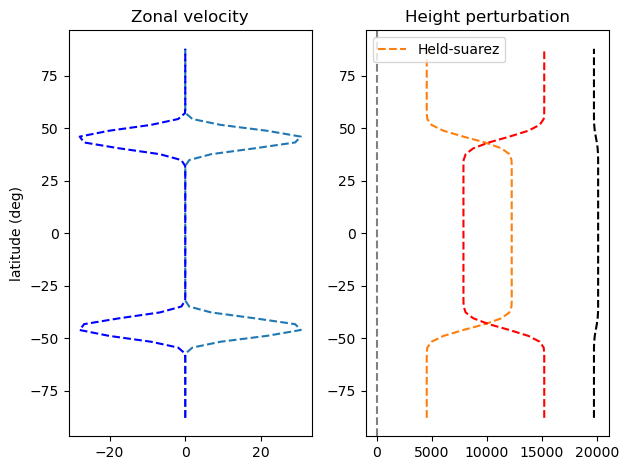

In [45]:
u10.change_scales(1)
h10.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)

fig, axs = plt.subplots(1,2)
axs[0].plot(u10['g'][0][0]/(meter/second), lat[0]*180/np.pi, '--', color='C0')
axs[0].plot(u20['g'][0][0]/(meter/second), lat[0]*180/np.pi, '--', color='b')
axs[0].set_title('Zonal velocity')
axs[0].set_ylabel('latitude (deg)')
axs[1].plot((h10['g'][0])/meter, lat[0]*180/np.pi, '--', color='C1', label='Held-suarez')
axs[1].plot((h20['g'][0])/meter, lat[0]*180/np.pi, '--', color='r')
axs[1].plot((h10['g'][0]+h20['g'][0])/meter, lat[0]*180/np.pi, '--', color='k')
axs[1].axvline(0.,color='gray',linestyle='--')
axs[1].set_title('Height perturbation')
axs[1].legend()
plt.tight_layout()